In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy
import os

path = 'Data'

In [2]:
def display_gray(x: np.array, normalized:bool = False):
    if not normalized:
        plt.imshow(x,cmap='gray',vmin=0,vmax=1)
    else:
        plt.imshow(x/x.max(),cmap='gray',vmin=0,vmax=1)

In [3]:
def display_axis(ax: plt.axis, x: np.array, title: str, normalized:bool = False):
    if not normalized:
        ax.imshow(x,cmap='gray',vmin=0,vmax=1)
    else:
        ax.imshow(x/x.max(),cmap='gray',vmin=0,vmax=1)
    ax.set_title(title,size=18)

In [4]:
def rel_l1_dist(x1: np.array, x2: np.array):
    return np.abs(x1-x2).sum()/np.abs(x1).sum()

In [5]:
image = Image.open(os.path.join(path,'Singles/house.png'))
img_data = np.asarray(image)/255

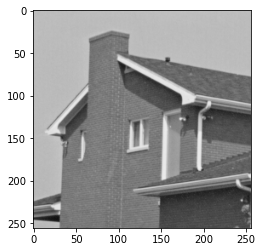

In [6]:
display_gray(img_data)

### 2D-Convolution

In [7]:
def conv2D(image: np.array, kernel: np.array = None):
    
    #Flip the kernel
    flipped_kernel = np.fliplr(kernel) 
    flipped_kernel = np.flipud(flipped_kernel)
    
    #Size Variables
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    
    #Output
    padding = kernel.shape[0]//2
    imagePadded = np.pad(image, ((padding,padding), (padding,padding)), constant_values = ((0,0),(0,0)))
    answer = np.zeros(image.shape)
    
    
    for x in range (image_h):
        for y in range (image_w):
            answer[x,y] = (kernel*imagePadded[x:x + kernel_w, y:y + kernel_h]).sum()
            
                    
    return answer
                    
        
            

In [8]:
def identity_filter(size: int):
    assert size%2 == 1
    iden_filt = np.zeros((size,size))
    iden_filt[size//2,size//2]=1
    return iden_filt

In [9]:
iden_filt = identity_filter(5)
print(iden_filt)
conv_iden = conv2D(img_data, iden_filt)
print(conv_iden)
assert np.abs(img_data-conv_iden).sum() == 0.0

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.7372549  0.73333333 0.73333333 ... 0.7372549  0.74117647 0.74117647]
 [0.7372549  0.73333333 0.73333333 ... 0.7372549  0.74117647 0.74117647]
 [0.7254902  0.74117647 0.72941176 ... 0.74509804 0.74117647 0.7372549 ]
 ...
 [0.72941176 0.72941176 0.72941176 ... 0.2745098  0.31372549 0.6627451 ]
 [0.72941176 0.73333333 0.72941176 ... 0.30588235 0.34509804 0.6627451 ]
 [0.7254902  0.73333333 0.73333333 ... 0.34509804 0.35294118 0.65098039]]


### Image Blurring and Denoising

Average/Box Filter: the standard box filter which computes the mean of all the pixels inside the filter.

In [10]:
def average_filter(size: int):
    assert size%2 == 1
    return 1.0 * np.ones((size,size))/(size**2)

### Gaussian Filter

$p(x,y) = \dfrac{1}{2\pi\sigma^2}\exp{\big(-\dfrac{(x-\mu_x)^2+(y-\mu_y)^2}{2\sigma^2}\big)}$

In [11]:
def gaussian_filter(size: int, sigma: float):
    
    gaussian = np.zeros((size,size))
    
    miux = size//2
    miuy = size//2
    
    total = 0
    
    for x in range(size):
        for y in range(size): 
            x1 = (sigma**2)*2*np.pi
            x2 = np.exp((-(x-miux)**2 - (y-miuy)**2)/(2*(sigma**2)))
            gaussian[x,y] = (x2/x1)
            total = total + (x2/x1)
            
    for x in range(size):
        for y in range(size): 
            gaussian[x,y] = gaussian[x,y]/total
    
    return gaussian
            
            
            
    
    

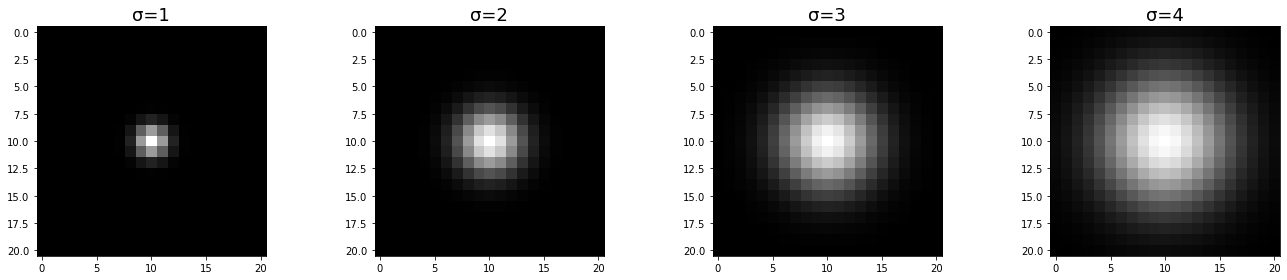

In [12]:
fig, ax = plt.subplots(1,4,figsize=(1 + 4*4.5,4))
for i in range(1,5):
    gauss_filt = gaussian_filter(21,i)
    display_axis(ax[i-1],gauss_filt,f'\u03C3={i}', normalized=True)
fig.tight_layout()
fig.savefig('Data/Solutions/gaussFilter.pdf', format='pdf', bbox_inches='tight')

### Image Blurring

#### Average Filter

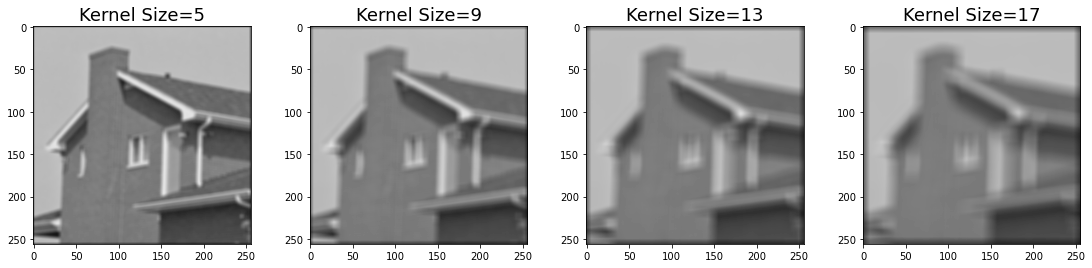

In [13]:
fig, ax = plt.subplots(1,4,figsize=(1 + 4*4.5,4))
for i in range(1,5):
    size = 4*i+1
    avg_filt = average_filter(size)
    conv_avg = conv2D(img_data, avg_filt)
    display_axis(ax[i-1],conv_avg,f'Kernel Size={size}')

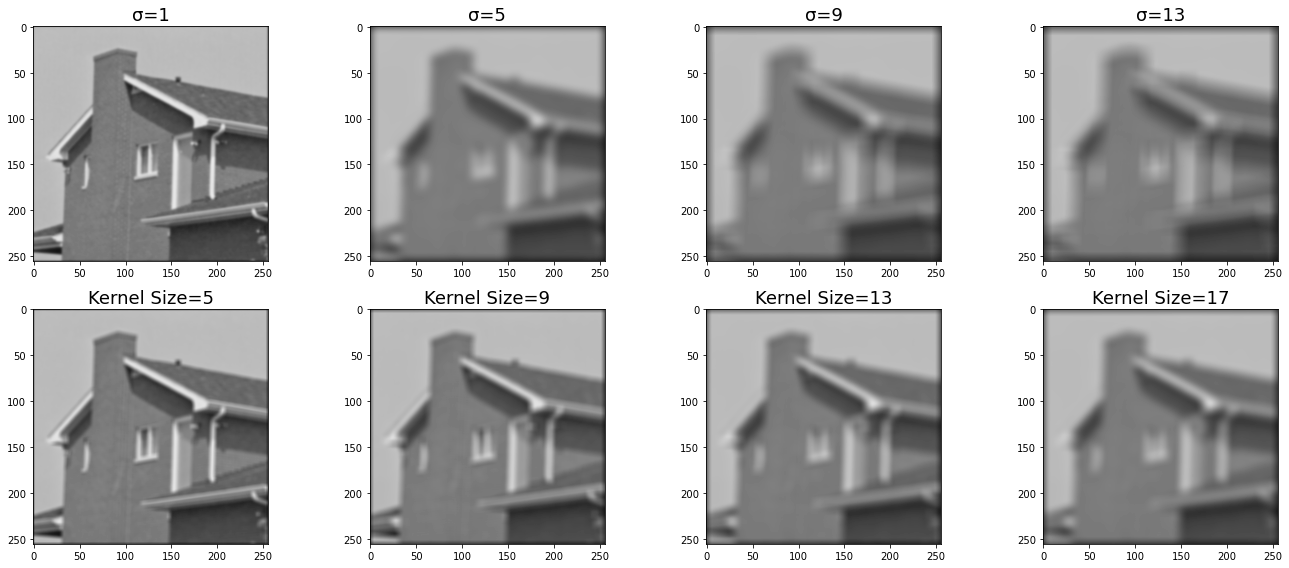

In [14]:
fig, ax = plt.subplots(2,4,figsize=(1 + 4*4.5,2*4))
for i in range(1,5):
    sigma = 4*(i-1)+1
    s = 4*i + 1
    gauss_filt = gaussian_filter(21,sigma)
    conv_gauss = conv2D(img_data, gauss_filt)
    display_axis(ax[0,i-1],conv_gauss,f'\u03C3={sigma}')
    gauss_filt = gaussian_filter(s,5)
    conv_gauss = conv2D(img_data, gauss_filt)
    display_axis(ax[1,i-1],conv_gauss,f'Kernel Size={s}')
fig.tight_layout()
fig.savefig('Data/Solutions/avgFilter.pdf', format='pdf', bbox_inches='tight')

## Image Denoising

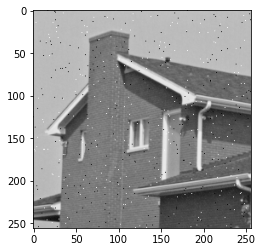

In [15]:
noisy_img_data = np.asarray(Image.open('Data/Singles/noisy_house.png'))
noisy_img_data = noisy_img_data/255
display_gray(noisy_img_data)

In [16]:
def median_filtering(image: np.array, kernel_size: int = None):
    #Variables
    image_h, image_w = image.shape
    
    #Output
    output = np.zeros(image.shape)
    
    #Padding
    padding = kernel_size//2
    imagePadded = np.pad(image, ((padding,padding), (padding,padding)), constant_values = ((0,0),(0,0)))
    
    #Loop
    
    for x in range(image_h):
        for y in range(image_w):
             output[x,y] = np.median(imagePadded[x: x + kernel_size, y: y + kernel_size])
    
    return output
    
    
            

In [17]:
avg_filt = average_filter(7)
gauss_filt = gaussian_filter(7,3)
avg_filt_noisy_img = conv2D(noisy_img_data, avg_filt)
gauss_filt_noisy_img = conv2D(noisy_img_data, gauss_filt)
median_filt_noisy_img = median_filtering(noisy_img_data,7)

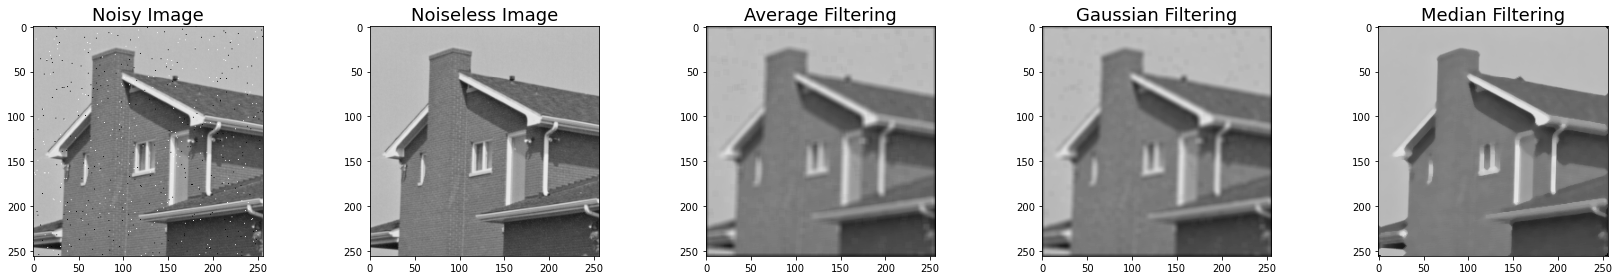

In [18]:
fig, ax = plt.subplots(1,5,figsize=(1 + 5*4.5,4))
display_axis(ax[0],noisy_img_data, 'Noisy Image')
display_axis(ax[1],img_data, 'Noiseless Image')
display_axis(ax[2],avg_filt_noisy_img,'Average Filtering')
display_axis(ax[3],gauss_filt_noisy_img,'Gaussian Filtering')
display_axis(ax[4],median_filt_noisy_img,'Median Filtering')
fig.tight_layout()
fig.savefig('Data/Solutions/question_3_6.pdf', format='pdf', bbox_inches='tight')

Relative absolute distance

In [19]:
print(f'Average Filtering: {rel_l1_dist(img_data, avg_filt_noisy_img)}')
print(f'Gaussian Filtering: {rel_l1_dist(img_data, gauss_filt_noisy_img)}')
print(f'Median Filtering: {rel_l1_dist(img_data, median_filt_noisy_img)}')

Average Filtering: 0.06525493187234264
Gaussian Filtering: 0.059951053670929656
Median Filtering: 0.03332913485508449


## Gradients

In [20]:
gradient_x = np.zeros((3,3))

for i in range(3):
    gradient_x[i][0] = -1
    
for j in range(3):
    gradient_x[j][2] = 1
        


In [21]:
gradient_y = np.zeros((3,3))

for i in range(3):
    gradient_y[0][i] = -1
    
for j in range(3):
    gradient_y[2][j] = 1

[[-1.  0.  1.]
 [-1.  0.  1.]
 [-1.  0.  1.]]
[[-1. -1. -1.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]]


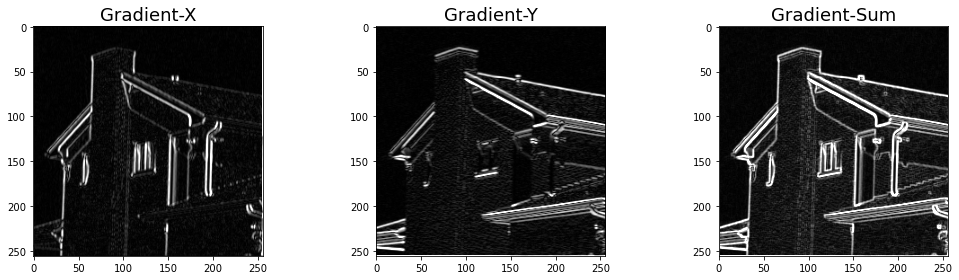

In [22]:
fig, ax = plt.subplots(1,3,figsize=(1 + 3*4.5,4))
print(gradient_x)
print(gradient_y)
img_gradient_x = conv2D(img_data, gradient_x)
img_gradient_y = conv2D(img_data, gradient_y)
display_axis(ax[0], np.abs(img_gradient_x), 'Gradient-X')
display_axis(ax[1], np.abs(img_gradient_y), 'Gradient-Y')
display_axis(ax[2], np.abs(img_gradient_x) + np.abs(img_gradient_y), 'Gradient-Sum')
fig.tight_layout()
fig.savefig('Data/Solutions/gradients.pdf', format='pdf', bbox_inches='tight')

In [23]:
#Code for 1D Gaussian
def gauss(x, miu, sigma):
    x1 = sigma * np.sqrt(2*np.pi)
    x2 = np.exp(-0.5 * ((x-miu)**2/(sigma**2)))
    return x2/x1
    
    
def filtering_2(image: np.array, kernel: np.array = None, sigma_int: float = None, norm_fac: float = None):
    
    #Flip the kernel
    flipped_kernel = np.fliplr(kernel) 
    flipped_kernel = np.flipud(flipped_kernel)
    
    #Size Variables
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    
    #Padding
    padding = kernel_w//2
    imagePadded = np.pad(image, ((padding,padding), (padding,padding)), constant_values = ((0,0),(0,0)))
    
    #Output
    answer = np.zeros(image.shape)
    
    #Looping
    for x in range(image_w):
        for y in range(image_h):
            
            #Setting up I(p)
            Ip = image[x,y]
            
            #Setting up I(q) 
            Iq = imagePadded[x: x + kernel_h, y: y + kernel_w]
            
            #Setting up the Gaussian along intensity dimension
            rangeGaussian = gauss(Ip - Iq, 0, sigma_int)
            
            
            #Implementing the double filter (Space + Range)
            doubleFilter = rangeGaussian * flipped_kernel
            
            #Summing up the values and normalize with sum of intensity and spatil filters
            answer[x,y] = np.sum(doubleFilter * Iq)/doubleFilter.sum()
            
    #Return answer
    return answer
            
            
    

In [24]:
gauss_filt = gaussian_filter(11,3)
gauss_filt_img_data = conv2D(img_data, gauss_filt)
filt_2_img_data = filtering_2(img_data, gauss_filt, sigma_int=0.2, norm_fac=0.0075) 

Comparison of the new filter with the gaussian filter should show that the new filter preserves edges while smoothing the remaining image.

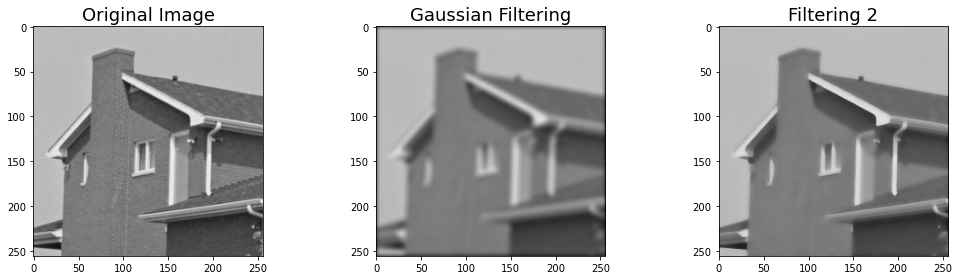

In [25]:
fig, ax = plt.subplots(1,3,figsize=(1 + 3*4.5,4))
display_axis(ax[0], img_data, 'Original Image')
display_axis(ax[1], gauss_filt_img_data, 'Gaussian Filtering')
display_axis(ax[2], filt_2_img_data, 'Filtering 2')
fig.tight_layout()
fig.savefig('Data/Solutions/filters.pdf', format='pdf', bbox_inches='tight')